## End of distribution Imputation ==> Feature-Engine


Feature-engine is an open source Python package originally designed to support this course, but has increasingly gained popularity and now supports transformations beyond those taught in the course. It was launched in 2017, and since then, several releases have appeared and a growing international community is beginning to lead the development.

- Feature-engine works like to Scikit-learn, so it is easy to learn
- Feature-engine allows you to implement specific engineering steps to specific feature subsets
- Feature-engine can be integrated with the Scikit-learn pipeline allowing for smooth model building
- 
**Feature-Engine allows you to design and store a feature engineering pipeline with different procedures for different variable groups.**

- Make sure you have installed feature-engine before running this notebook.

## In this demo

We will use Feature-engine to perform end of tail / extreme imputation using the Ames House Price Dataset.

- To download the dataset visit the lecture **Datasets** in **Section 1** of the course.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

# to split the datasets
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

# from feature-engine
from feature_engine.imputation import EndTailImputer

In [2]:
# let's load the dataset with a selected group of variables

cols_to_use = [
    'BsmtQual', 'FireplaceQu', 'LotFrontage', 'MasVnrArea', 'GarageYrBlt',
    'SalePrice'
]

data = pd.read_csv('../houseprice.csv', usecols=cols_to_use)
data.head()

,LotFrontage,MasVnrArea,BsmtQual,FireplaceQu,GarageYrBlt,SalePrice
0,65.0,196.0,Gd,NaN,2003.0,208500
1,80.0,0.0,Gd,TA,1976.0,181500
2,68.0,162.0,Gd,TA,2001.0,223500
3,60.0,0.0,TA,Gd,1998.0,140000
4,84.0,350.0,Gd,TA,2000.0,250000


In [3]:
data.isnull().mean()

LotFrontage    0.177397
MasVnrArea     0.005479
BsmtQual       0.025342
FireplaceQu    0.472603
GarageYrBlt    0.055479
SalePrice      0.000000
dtype: float64

All the predictor variables contain missing data.

In [4]:
# let's separate into training and testing set

# first drop the target from the feature list
cols_to_use.remove('SalePrice')

X_train, X_test, y_train, y_test = train_test_split(
    data[cols_to_use],
    data['SalePrice'],
    test_size=0.3,
    random_state=0)

X_train.shape, X_test.shape

((1022, 5), (438, 5))

### Feature-Engine captures the numerical variables automatically

In [5]:
# we specify whether we want to find the values using
# the gaussian approximation or the inter-quartile range
# proximity rule.

# in addition we need to specify if we want the values placed at 
# the left or right tail

imputer = EndTailImputer(imputation_method='gaussian', tail='right')

In [6]:
# we fit the imputer

imputer.fit(X_train)

EndTailImputer()

In [7]:
# we see that the imputer found the numerical variables

imputer.variables_

['LotFrontage', 'MasVnrArea', 'GarageYrBlt']

In [8]:
# here we can see the values that will be used
# to replace NA for each variable

imputer.imputer_dict_

{'LotFrontage': 138.9022201686726,
 'MasVnrArea': 648.3947111415165,
 'GarageYrBlt': 2052.9707419772235}

In [9]:
# and this is how those values were calculated
# which is how we learnt in the first notebooks of
# this section

X_train[imputer.variables_].mean() + 3 * X_train[imputer.variables_].std()

LotFrontage     138.902220
MasVnrArea      648.394711
GarageYrBlt    2052.970742
dtype: float64

In [10]:
# feature-engine returns a dataframe

tmp = imputer.transform(X_train)
tmp.head()

,BsmtQual,FireplaceQu,LotFrontage,MasVnrArea,GarageYrBlt
64,Gd,NaN,138.90222,573.0,1998.000000
682,Gd,Gd,138.90222,0.0,1996.000000
960,TA,NaN,50.00000,0.0,2052.970742
1384,TA,NaN,60.00000,0.0,1939.000000
1100,TA,NaN,60.00000,0.0,1930.000000


In [11]:
# let's check that the numerical variables don't
# contain NA any more

tmp[imputer.variables_].isnull().mean()

LotFrontage    0.0
MasVnrArea     0.0
GarageYrBlt    0.0
dtype: float64

## Feature-engine allows you to specify variable groups

In [12]:
# let's impute 2 of the 3 numerival variables

# let's also select the IQR proximity rule on the left tail

imputer = EndTailImputer(imputation_method='iqr', tail='left',
                         variables=['LotFrontage', 'MasVnrArea'])

imputer.fit(X_train)

EndTailImputer(imputation_method='iqr', tail='left',
               variables=['LotFrontage', 'MasVnrArea'])

In [13]:
# now the imputer uses only the variables we indicated

imputer.variables_

['LotFrontage', 'MasVnrArea']

In [14]:
# and we can see the value assigned to each variable

imputer.imputer_dict_

{'LotFrontage': -8.0, 'MasVnrArea': -510.0}

In [15]:
# feature-engine returns a dataframe

tmp = imputer.transform(X_train)

# let's check null values are gone
tmp[imputer.variables_].isnull().mean()

LotFrontage    0.0
MasVnrArea     0.0
dtype: float64

## Feature-engine can be used with the Scikit-learn pipeline

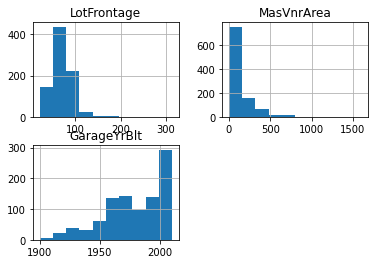

In [16]:
# let's look at the distributions to determine the
# end tail value selection method

X_train.hist()
plt.show()

All variables are skewed. For this demo, I will use the proximity rule for GarageYrBlt and MasVnrArea, and the Gaussian approximation for LotFrontage.

In [17]:
pipe = Pipeline([
    ('imputer_skewed', EndTailImputer(imputation_method='iqr', tail='right',
                                      variables=['GarageYrBlt', 'MasVnrArea'])),

    ('imputer_gaussian', EndTailImputer(imputation_method='gaussian', tail='right',
                                        variables=['LotFrontage'])),
])

In [18]:
pipe.fit(X_train)

Pipeline(steps=[('imputer_skewed',
                 EndTailImputer(imputation_method='iqr',
                                variables=['GarageYrBlt', 'MasVnrArea'])),
                ('imputer_gaussian',
                 EndTailImputer(variables=['LotFrontage']))])

In [19]:
pipe.named_steps['imputer_skewed'].imputer_dict_

{'GarageYrBlt': 2121.0, 'MasVnrArea': 680.0}

In [20]:
pipe.named_steps['imputer_gaussian'].imputer_dict_

{'LotFrontage': 138.9022201686726}

In [21]:
# let's transform the data with the pipeline
tmp = pipe.transform(X_train)

# let's check null values are gone
tmp.isnull().mean()

BsmtQual       0.023483
FireplaceQu    0.467710
LotFrontage    0.000000
MasVnrArea     0.000000
GarageYrBlt    0.000000
dtype: float64

There are no more null values for the 3 imputed numerical variables.